## Описание исследования

Данное исследование нацелено на предсказание снижения пользовательской активности по выделенному набору данных, задача бинарной классификации, где целевой показатель "Покупательская активность" либо "Снизилась", либо "Прежний уровень". 

Шаги решения данной задачи: 
1. Импорт необходимые библиотеки
2. Загрузить необходимую информацию, проверить информацию по столбцам
3. Выполнить предобработку данных, проверить пропуски, дубликаты (явные и неявные)
4. Выполнить исследовательский анализ информации
5. Выполнить объединение таблиц
6. Выполнить корреляционный анализ 
7. Пройтись по всем моделям классификации с использованием паплайнов 
8. Провести анализ признаков лучшей модели, SHAP 
9. Произвести сегментацию покупателей 
10. Написать общий вывод. 

## Импорт необходимых библиотек 

In [4]:
!pip install shap -q
!pip install -Uq scikit-learn
!pip install phik -q

In [5]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import shap
import sklearn

## Загрузка данных 

In [7]:
market_file = pd.read_csv(r"C:\Users\nssavinov\Desktop\Пректы практикум\7 Обучение с учителем качество модели\market_file.csv")
market_money = pd.read_csv (r"C:\Users\nssavinov\Desktop\Пректы практикум\7 Обучение с учителем качество модели\market_money (1).csv")
market_time = pd.read_csv (r"C:\Users\nssavinov\Desktop\Пректы практикум\7 Обучение с учителем качество модели\market_time.csv")
money = pd.read_csv (r"C:\Users\nssavinov\Desktop\Пректы практикум\7 Обучение с учителем качество модели\money.csv", sep = ';', decimal = ',')

Изучим подробно каждую таблицу на соответствие описанию предоставленному в задаче. 

In [9]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Наполнение данных соответсвует описанию в данной таблице

In [11]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [12]:
market_money['Период'].value_counts()

Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

In [13]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [14]:
market_time['Период'].value_counts()

Период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

In [15]:
# В предъобработке данных, в данной таблце необходимо будет скорректирвать наименование

In [16]:
money.head() #Выгружается значение с запятой, 
#при загрузке таблицы поставим значение разделителя 
#и после в этой таблице уже будут корректные значения 

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Приведем все к нижнему регистру

In [18]:
tables = [market_file, market_money, market_time, money]
for i in tables:
    i.rename (columns = str.lower, inplace = True)
    i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская активность            1300 non-null   object 
 2   тип сервиса                          1300 non-null   object 
 3   разрешить сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

По результату прохождения данного было сделано следующее: 
1. выгружены все таблицы
2. проведено сравнение с описанием, критических пунктов не обнаружено 
3. Изучены пропуски, пропусков не обнаруженно 

## Предобработка данных

In [21]:
for i in tables: 
    print (i.duplicated().sum())

0
0
0
0


В таблицах дубликатов нет. 

После проведенного анализа по несоответствию типов данных, несоответствий *не обнаруженно* 

Произведем проверку на неявные дубликаты

In [25]:
implicit_duplicates_market_file = ['покупательская активность', 'тип сервиса', 'разрешить сообщать', 'популярная_категория']

for i in implicit_duplicates_market_file:
    print (i, list(market_file[i].sort_values().unique()))

покупательская активность ['Прежний уровень', 'Снизилась']
тип сервиса ['премиум', 'стандарт', 'стандартт']
разрешить сообщать ['да', 'нет']
популярная_категория ['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда', 'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья', 'Товары для детей']


Обнаружен неявный дубликат в поле "тип сервиса", Заменим стандартт на стандарт

In [27]:
market_file.loc [market_file['тип сервиса'] == 'стандартт', 'тип сервиса'] = 'стандарт'
market_file['тип сервиса'].value_counts()

тип сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

In [28]:
#После изменения, проверим таблицу на дубликаты 
market_file.duplicated().sum()
#Дубликатов явных все также нет 

0

In [29]:
#проверим следующие 2 талблицы на дубликаты 
display (market_money['период'].unique())
display ('')
display (market_time['период'].unique())

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

''

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

После проверки было определенно, что в таблице market_money дубликатов нет. 

В таблице market_time нужно исправить ошибку  с предыдцщий_месяц на предыдущий_месяц

In [32]:
market_time.loc[ market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'
display (market_time['период'].unique())

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [33]:
#Скорректируем наименования столбцов таблицы о пользовательских данных
market_file = market_file.rename (columns = {'покупательская активность' : 'покупательская_активность',
                                            'тип сервиса' : 'тип_сервиса',
                                            'разрешить сообщать' : 'разрешить_сообщать'})
market_file.head(1)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5


**В результате проведения данного пункта было выполнено следующее:** 
1. Проверены все таблицы на наличие явных дубликатов - явных дубликатов не обнаруженно 
2. Обнаружены неявные дубликаты в таблице содержащей данные о поведении покупателя, в поле "Тип сервиса", исправлено 
3. После исправления, проведена повторная оценка явных дубликатов -  не обнаруженно 
4. Проверены типы данных всех таблиц, все типы данных соответствуют описанию 
5. Значение периода в таблице о времени персонажа на сайте скорректированно 
6. Скорректированы наименования столбцов в таблице о пользователях 

## Исследовательский анализ 

Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.



In [36]:
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


### Изучение количественных признаков

In [38]:
def col_prisnak (x, y):
    for i in x:
        #строим гистограмму
        plt.hist (y[i])
        plt.title (i)
        plt.xlabel (i)
        plt.ylabel ('Частота встречаемости')
        plt.show()
        #стороим ящик с усами 
        plt.boxplot (y[i], vert = False)
        plt.title(i)
        plt.xlabel ('Значения')
        plt.ylabel ('Диаграмма размаха')
        plt.show()
        display (y[i].describe() [['min', 'max', 'mean', '50%']])

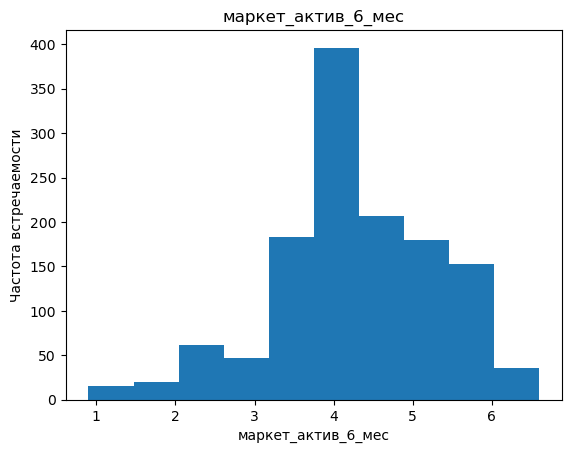

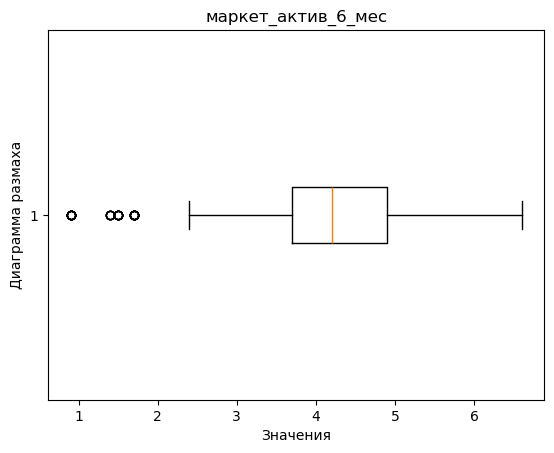

min     0.900000
max     6.600000
mean    4.253769
50%     4.200000
Name: маркет_актив_6_мес, dtype: float64

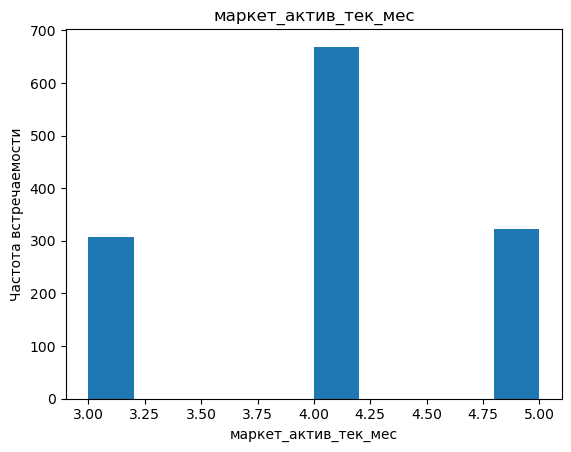

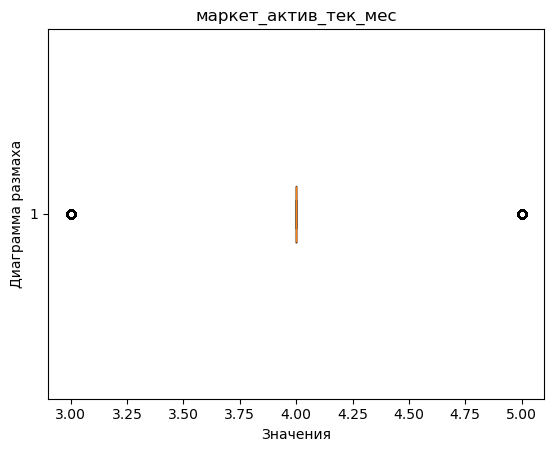

min     3.000000
max     5.000000
mean    4.011538
50%     4.000000
Name: маркет_актив_тек_мес, dtype: float64

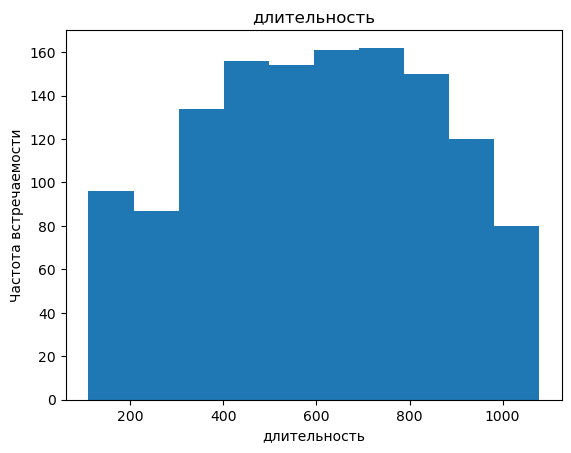

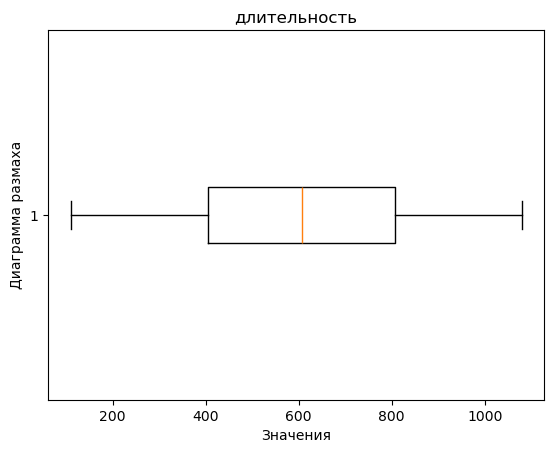

min      110.000000
max     1079.000000
mean     601.898462
50%      606.000000
Name: длительность, dtype: float64

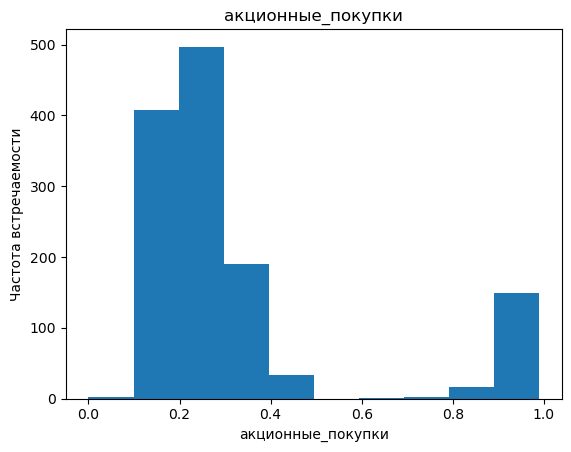

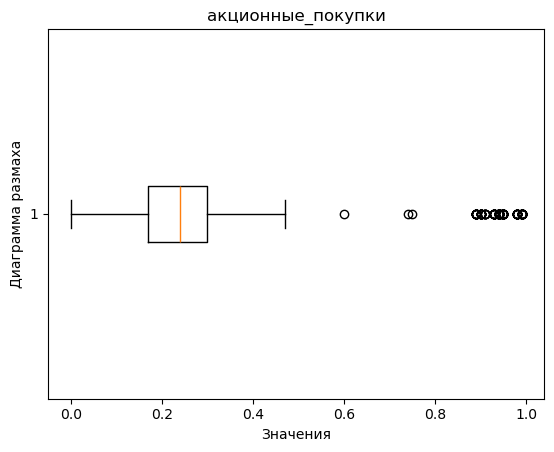

min     0.000000
max     0.990000
mean    0.319808
50%     0.240000
Name: акционные_покупки, dtype: float64

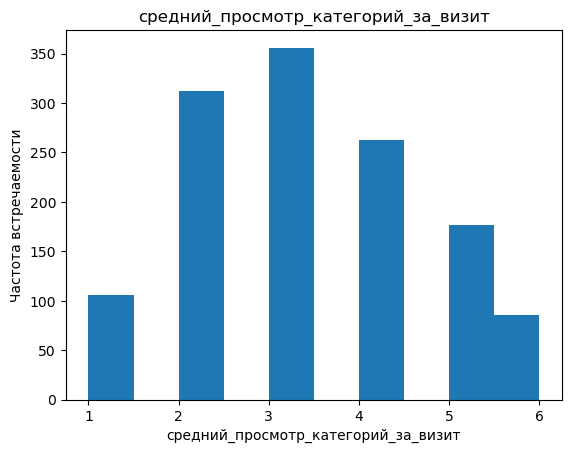

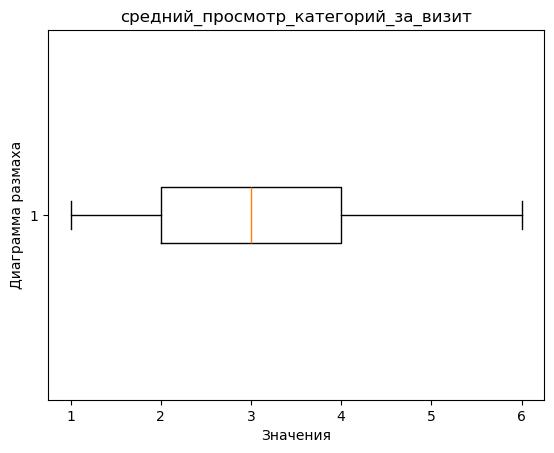

min     1.00
max     6.00
mean    3.27
50%     3.00
Name: средний_просмотр_категорий_за_визит, dtype: float64

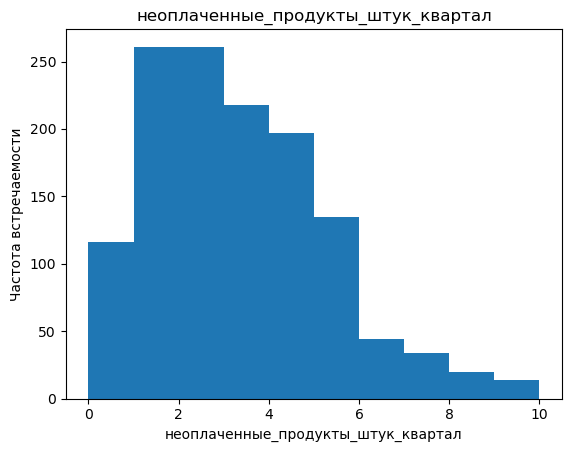

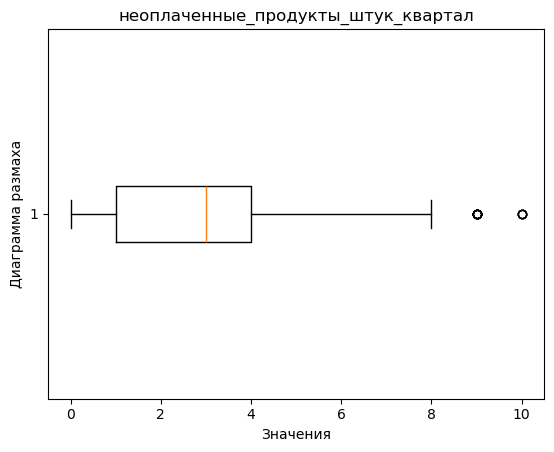

min      0.00
max     10.00
mean     2.84
50%      3.00
Name: неоплаченные_продукты_штук_квартал, dtype: float64

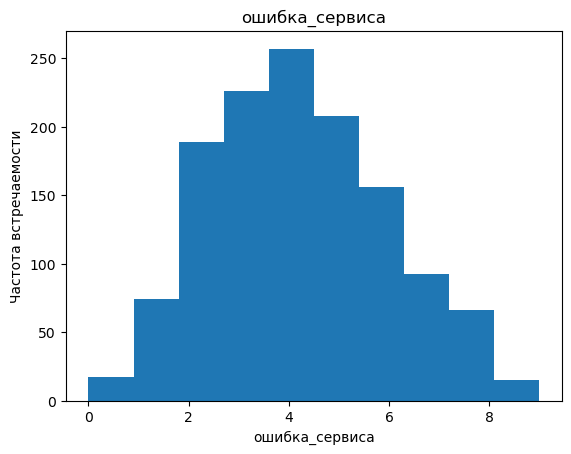

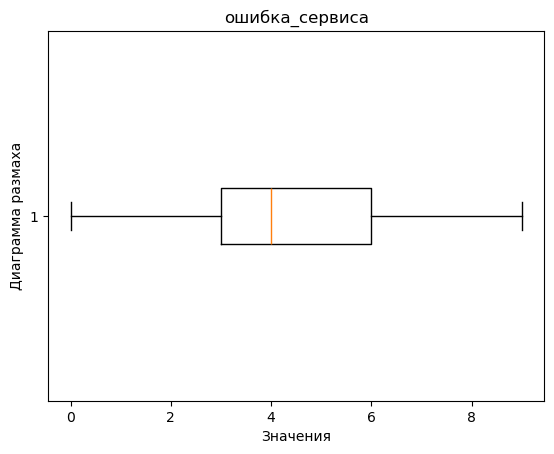

min     0.000000
max     9.000000
mean    4.185385
50%     4.000000
Name: ошибка_сервиса, dtype: float64

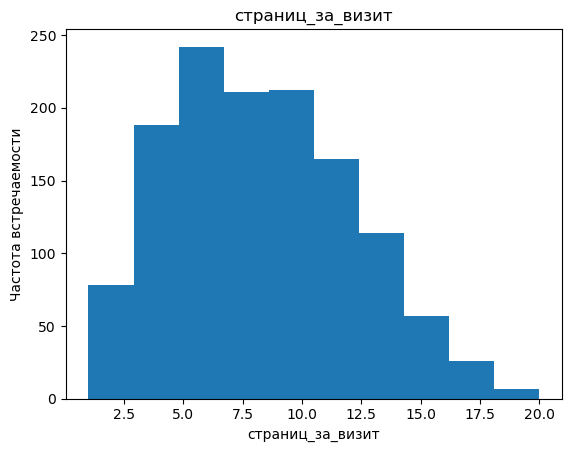

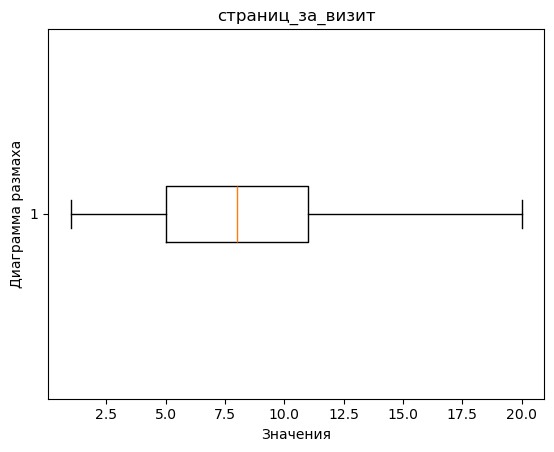

min      1.000000
max     20.000000
mean     8.176923
50%      8.000000
Name: страниц_за_визит, dtype: float64

In [39]:
quntative = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
             'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал',
            'ошибка_сервиса', 'страниц_за_визит']
col_prisnak (quntative, market_file)

После проведенного исследовательского анализа по таблице **market_file**, сделаем вывод по следующим показателям:
1. Макет_активности_6_месяц - показатель имеет нормальное распределением, у которого среднее значение и медиана практически совпадают друг с другом, имеются некоторые выбросы в количестве 3х штук, но избавляться от них не будем, т.к. эти значения могут показывать клиентов которые отказались от рассылок, но все равно делали покупки, либо недавно зарегистрировавшихся. (Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.)
2. Макет_активности_тек_месяц -  среднее и медианное значение = 4, выбросы в 3 и 5 значений не являются критическими, избавляться от них или заменять меданными не будем. 
3. Длительность все ок, отклонений нет 
4. Акционные_покупки - распределение корректное, есть отклонение в лице большого кол-ва поккупок только по акциям, история реальная, часто люди закупаются только в моменты распродаж или акций. Вывод: от этих данных не избавляемся. 
5. Средний просмотр категорий за визит - все ок 
6. Неолаченные продукты - есть 2 выброса, но считаем что имеет место быть, т.к. пользователь мог набрать товаров. 
7. Ошибка сервиса - ОК 
8. Страниц за визит - ОК. 

***Произведем исследование market_money  *** 

В таблице market_money поймем есть ли пользователи, с покупательский активностью менее 3х месяцев. Это означает что нужно отобрать пользователей у которых в одном из месяцев выручка = 0 

In [43]:
list (market_money [market_money ['выручка'] == 0] ['id'].unique())

[215348, 215357, 215359]

*3 пользователя с покупательской активностью менее 3х месяцев*

Удалим их из таблицы, а после изучим 

In [45]:
market_money = market_money[ ~market_money['id'].isin(market_money[market_money['выручка'] == 0]['id'].unique())]

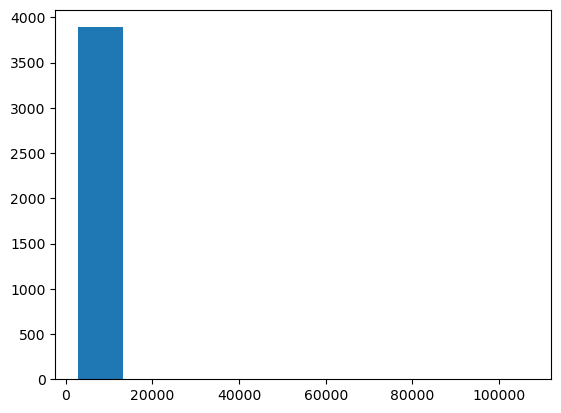

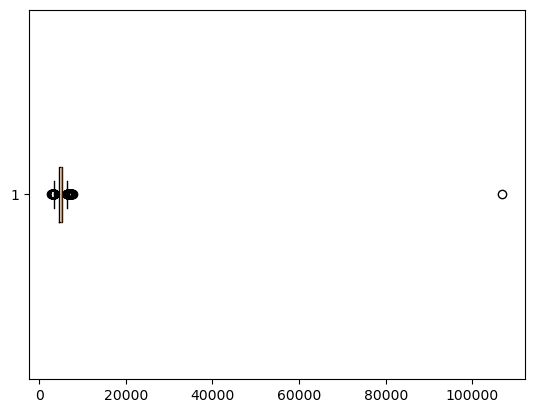

In [46]:
plt.hist (market_money['выручка']);
plt.show()
plt.boxplot (market_money['выручка'], vert = False);

In [47]:
#Посмотрим кто сделал покупок в месяц более чем на 100000 рублей 
display (market_money[ market_money ['выручка'] > 50000])
# проверим в других таблицах значения 215380
display (money[ money['id'] == 215380])
market_file[ market_file['id'] == 215380]

,id,период,выручка
98,215380,текущий_месяц,106862.2


,id,прибыль
32,215380,3.88


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


Для таких значений выручки такие значения прибыли невозможны, поэтому избавимся от этого выброса, заменив его медианной 

In [49]:
market_money.loc [ market_money ['выручка'] > 50000, 'выручка'] = market_money ['выручка'].median ()

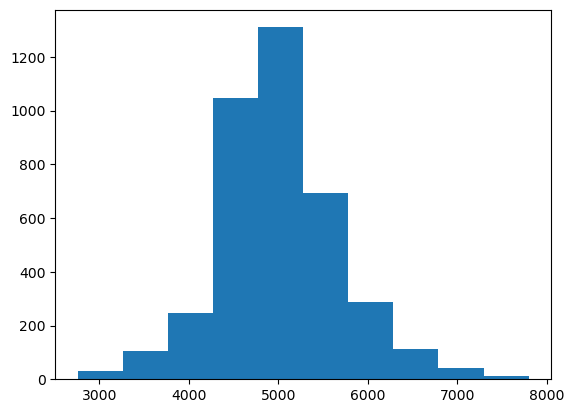

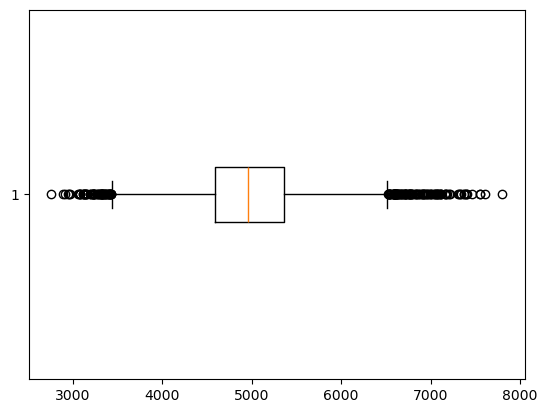

In [50]:
plt.hist (market_money['выручка']);
plt.show()
plt.boxplot (market_money['выручка'], vert = False);

растпределение выглядит корректным, выбросы имеются но из огромное кол-во и она в пределах допустимых значений. 

***Произведем исследование market_time *** 

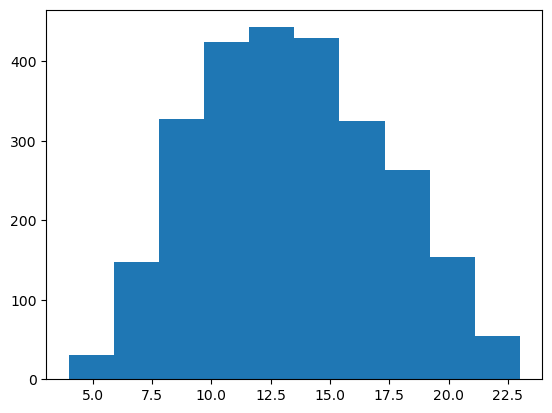

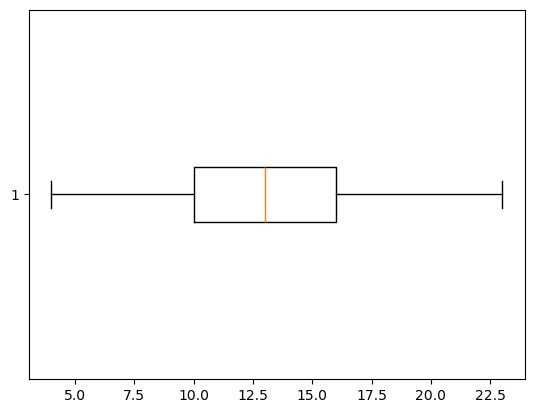

In [53]:
plt.hist (market_time['минут']);
plt.show()
plt.boxplot (market_time['минут'], vert = False);

В данной таблице все корректно.

***Произведем исследование money*** 

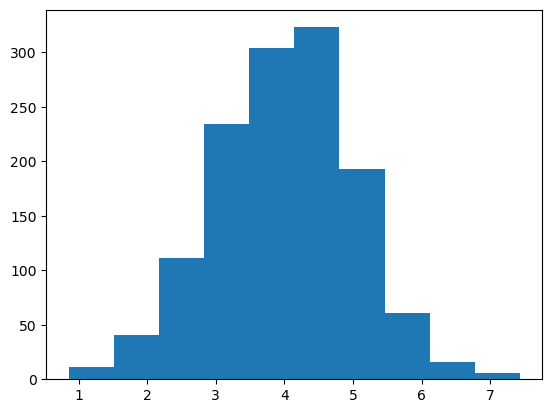

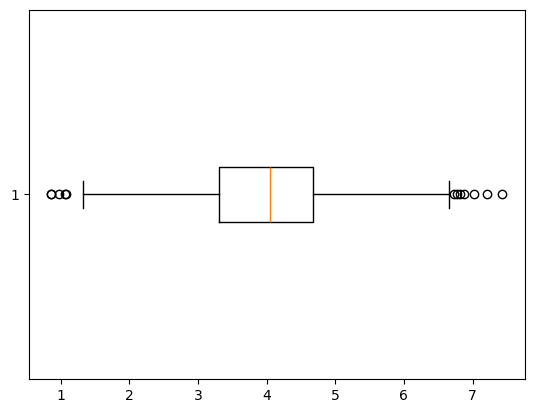

In [56]:
plt.hist (money['прибыль']);
plt.show()
plt.boxplot (money['прибыль'], vert = False);

Прибыль распределяется корректно, выбросы есть но в разумных пределах

### Исследование категориальных переменных 

In [59]:
quality = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

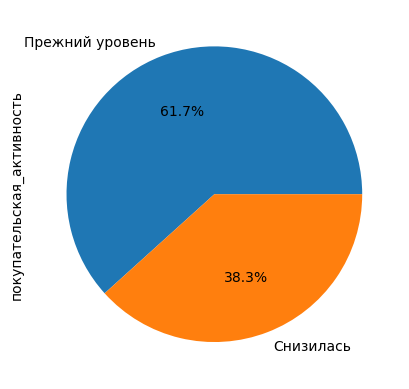

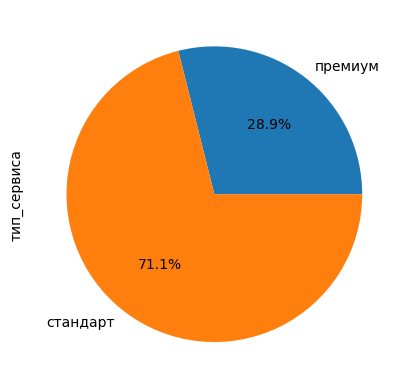

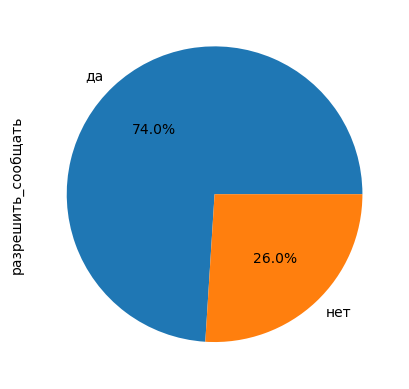

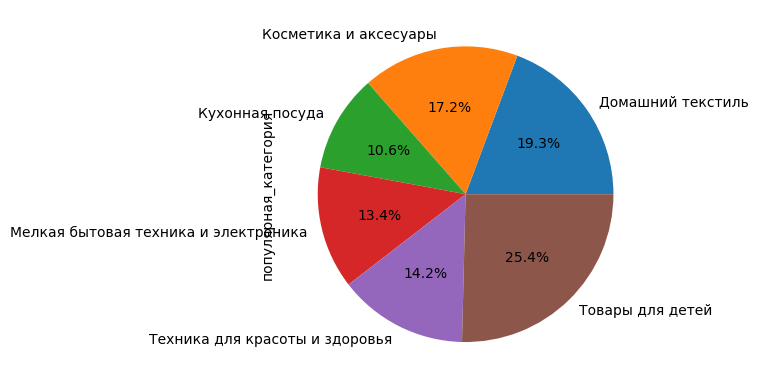

In [60]:
for i in quality:
    (market_file
    .groupby(i) [i]
    .count()
    .plot (kind = 'pie',  autopct = '%1.1f%%'))
    plt.title = i 
    plt.show()

In [61]:
(market_file
.groupby('популярная_категория') ['популярная_категория']
.count()
.sort_values(ascending = False))

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

**Вывод**

В результате выполнения данного пункта можно сделать следующий вывод, что: 

Колличественные переменные: 
Таблица market_file
1. Макет_активности_6_месяц - показатель имеет нормальное распределением, у которого среднее значение и медиана практически совпадают друг с другом, имеются некоторые выбросы в количестве 3х штук, но избавляться от них не будем, т.к. эти значения могут показывать клиентов которые отказались от рассылок, но все равно делали покупки, либо недавно зарегистрировавшихся. (Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.)
2. Макет_активности_тек_месяц -  среднее и медианное значение = 4, выбросы в 3 и 5 значений не являются критическими, избавляться от них или заменять меданными не будем. 
3. Длительность все ок, отклонений нет 
4. Акционные_покупки - распределение корректное, есть отклонение в лице большого кол-ва поккупок только по акциям, история реальная, часто люди закупаются только в моменты распродаж или акций. Вывод: от этих данных не избавляемся. 
5. Средний просмотр категорий за визит - все ок 
6. Неолаченные продукты - есть 2 выброса, но считаем что имеет место быть, т.к. пользователь мог набрать товаров. 
7. Ошибка сервиса - ОК 
8. Страниц за визит - ОК. 
Таблица market_money
1. Отсеяны пользователи с активностью менее 3х месяцев
2. Найден критический выброс, данное значение проверено, что является выбросом, по значению прибыли. Заменено на медиану. 
Таблица market_time
1. Распределение корректное, выбросов нет 
Таблица money
1. Распределение корректное, выбросов нет 

Качественные переменные: 
1. У 38,3% пользователей снизилась покупательская активность 
2. 29% пользователей являются Примиум пользователямми
3. 26% пользователей отказались от рассылки сообщений 
4. Самые популярные товары - товары для детей, а наименьшей популярностью обладает категория Кухонная посуда

***Анализ зависимостей между показателями и корреляционных коэф. будет происходить далее***

## Объединение таблиц
4.1 Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 

4.2 Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

### Подготовка таблиц market_money и market_time

In [65]:
market_money_final = market_money.pivot_table (index = 'id', columns = 'период', values = 'выручка', aggfunc = 'sum').reset_index()

In [66]:
market_money_final = market_money_final.rename (columns = {'предыдущий_месяц' : 'выручка_пред',
                                     'препредыдущий_месяц' : 'выручка_препред',
                                     'текущий_месяц' : 'выручка_тек'})
market_money_final.head()
#market_money готова к объединению

период,id,выручка_пред,выручка_препред,выручка_тек
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [67]:
market_time_final = market_time.pivot_table (index = 'id', columns = 'период', values = 'минут', aggfunc = 'sum').reset_index()

In [68]:
market_time_final = market_time_final.rename (columns = {'предыдущий_месяц' : 'мин_пред',
                                     'текущий_месяц' : 'мин_тек'})
market_time_final.head()
#подготовлена еще одна таблица

период,id,мин_пред,мин_тек
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


### Объединение таблиц
Произведем объединение 3х таблиц: market_time_final, market_money_final, market_file в общем датафрейме под нименованием DF. 

необходимо учесть что в исследовательском анализе мы избавились от 3х пользователей которые не совершали покупки. 
поэтому в обзем датасете будет 1297 строк, необходимо проверить 


In [70]:
dataframe = pd.merge (market_file, market_money_final, left_on = 'id', right_on = 'id')

In [71]:
# Check it 
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская_активность            1297 non-null   object 
 2   тип_сервиса                          1297 non-null   object 
 3   разрешить_сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  ошибка_сервиса                

In [72]:
dataframe = pd.merge (dataframe, market_time_final, left_on = 'id', right_on = 'id')
X_segmentation = dataframe.copy() #используется в пункте 10 
dataframe = dataframe.drop (columns = 'id', axis =1)

In [73]:
# Check it 
display (dataframe.info())
dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1297 non-null   object 
 1   тип_сервиса                          1297 non-null   object 
 2   разрешить_сообщать                   1297 non-null   object 
 3   маркет_актив_6_мес                   1297 non-null   float64
 4   маркет_актив_тек_мес                 1297 non-null   int64  
 5   длительность                         1297 non-null   int64  
 6   акционные_покупки                    1297 non-null   float64
 7   популярная_категория                 1297 non-null   object 
 8   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  ошибка_сервиса                       1297 non-null   int64  
 11  страниц_за_визит              

None

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред,выручка_препред,выручка_тек,мин_пред,мин_тек
0,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


**Вывод** 
По данному пункту, 
1. свортировали из таблиц времени и выручки помесячные значения
2. Объеденили все таблицы, итоговая таблица сохранила необходимые значения

## Корреляционный анализ

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

Изучим коэф. линейной корреляции Пирсона 

In [77]:
# plt.figure (figsize = (10,8))
# sns.heatmap(dataframe.corr(), annot = True, cmap = 'cividis')

Исходя из построенной тепловой карты, мультиколлинеарности нет

In [79]:
number_type = dataframe.select_dtypes(include = 'number').columns

<Axes: >

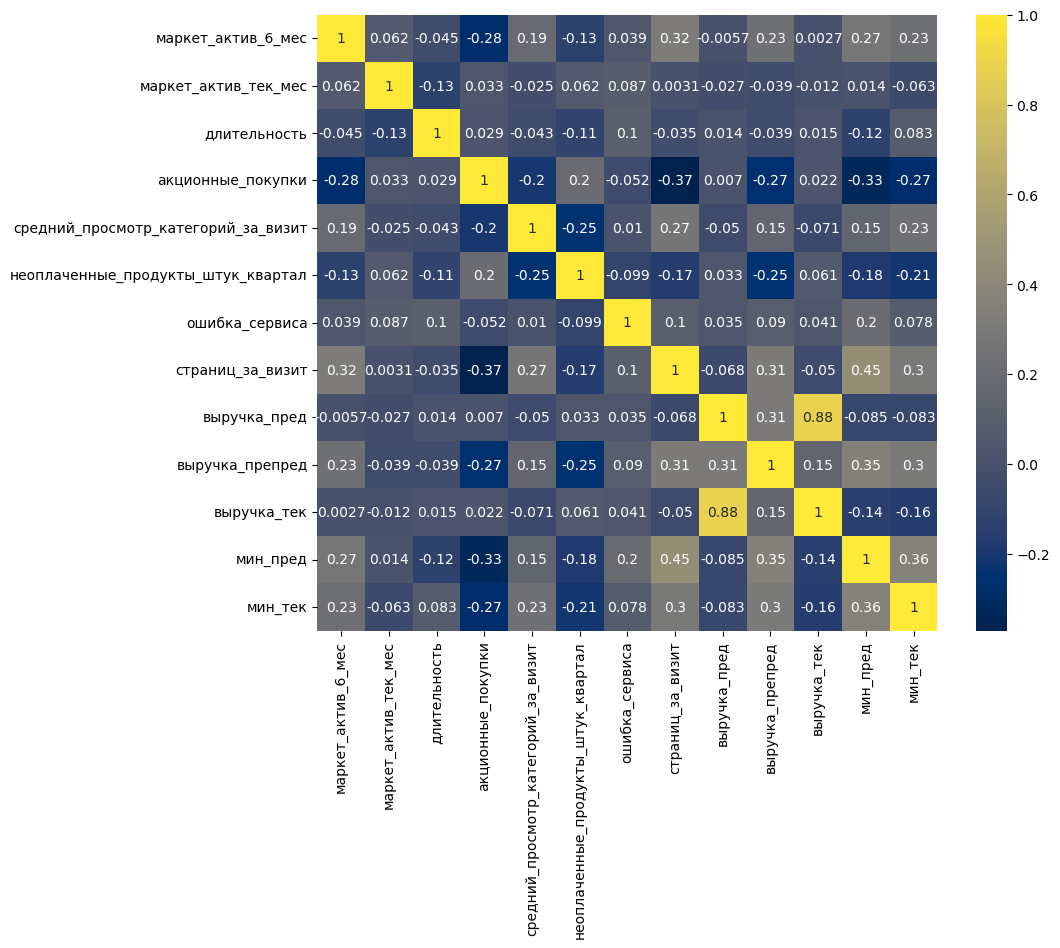

In [80]:
plt.figure (figsize = (10,8))
sns.heatmap(dataframe[number_type].corr(method = 'spearman'), annot = True, cmap = 'cividis')

Принято считать, что мультиколлинеарностью являются значения с коэффициентом корреляции > 90%, в нашем случае таких нет, необходимо дальнейшее исследование. 

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_пред', 'выручка_препред', 'выручка_тек', 'мин_пред', 'мин_тек']


<Axes: >

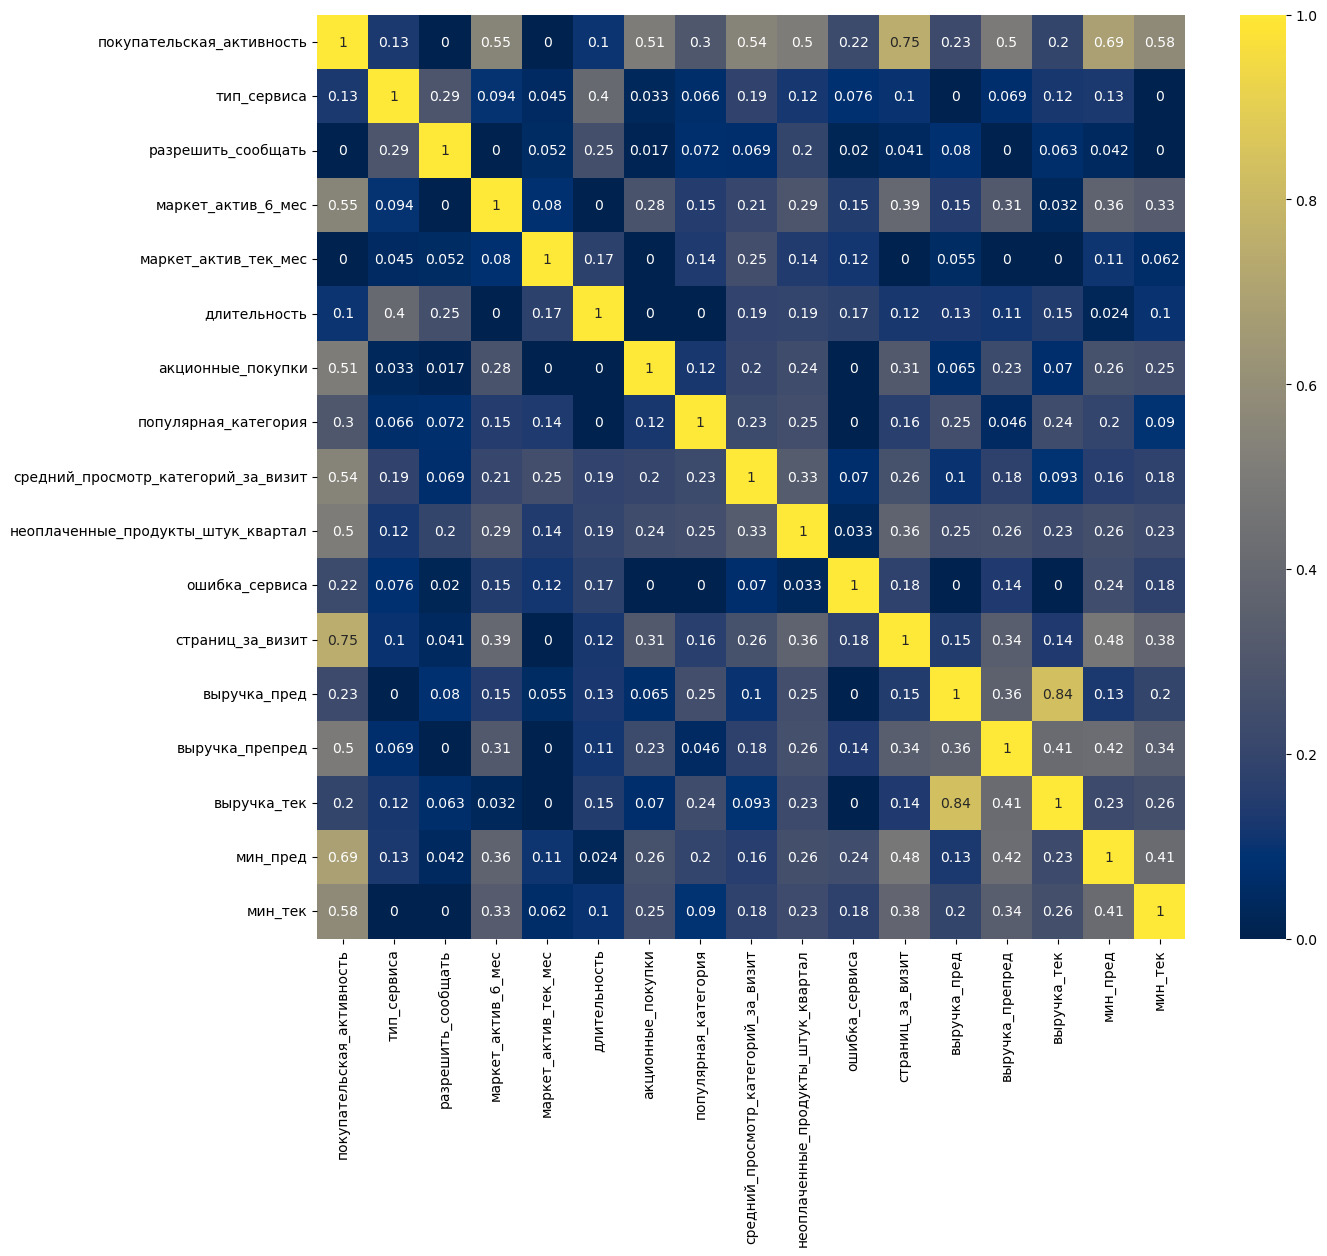

In [82]:
plt.figure (figsize = (14,12))
sns.heatmap (dataframe.phik_matrix(), annot = True, cmap = 'cividis')

In [84]:
# проверим VIF

num_cols = list (dataframe.select_dtypes (include = 'number').columns)
dataframe_vif = dataframe[num_cols]


X = add_constant (dataframe_vif)

vif_data = pd.Series ([variance_inflation_factor(X.values, i)
                      for i in range (X.shape[1])],
                     index = X.columns)
display (vif_data)

const                                  352.795434
маркет_актив_6_мес                       1.222057
маркет_актив_тек_мес                     1.044482
длительность                             1.099467
акционные_покупки                        1.186340
средний_просмотр_категорий_за_визит      1.178637
неоплаченные_продукты_штук_квартал       1.198187
ошибка_сервиса                           1.079306
страниц_за_визит                         1.417206
выручка_пред                             4.236188
выручка_препред                          1.612443
выручка_тек                              3.870497
мин_пред                                 1.527000
мин_тек                                  1.321108
dtype: float64

В разных источниках по разному, но принято считать, что мультиколлинеарностью обладают показатели у которых значение VIF > 5 или > 10, в нашем случае таких значений нет. 


**Вывод по данному пункту** : 
1. Мультиколлинарности среди признаков нет, проверено на коэф. Пирсона, Спирмана, phik_matrix, vif
2. При использовании МО необходимо применять регуляризацию. 

## Примените все изученные модели. Для этого используйте пайплайны.
6.1 Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.
Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.

6.2 Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

6.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:
использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

In [88]:
# Выделим X и y 
X = dataframe.drop (columns = 'покупательская_активность', axis = 1)
y = dataframe['покупательская_активность']
y = y.replace  ('Снизилась', 1)
y = y.replace  ('Прежний уровень', 0)
RANDOM_STATE = 44
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split (X,
                                                    y,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y)

ohe_columns = ['популярная_категория']

ord_columns = ['тип_сервиса', 'разрешить_сообщать']

num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
              'выручка_пред', 'выручка_препред', 'выручка_тек', 'мин_пред', 'мин_тек',
               'неоплаченные_продукты_штук_квартал', 'страниц_за_визит', 'средний_просмотр_категорий_за_визит',
               'ошибка_сервиса']

C:\Users\nssavinov\AppData\Local\Temp\ipykernel_11312\1340432551.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace  ('Прежний уровень', 0)


In [90]:
# Начинаем формировать пайплайн 
ohe_pipeline = Pipeline (
    [
        ('ohe',
        OneHotEncoder (drop='first', handle_unknown = 'ignore', sparse_output = False)
        )
    ]
)

ord_pipeline = Pipeline (
    [
        ('ord',
        OrdinalEncoder(
            categories = [
                ['стандарт', 'премиум'],
                ['нет', 'да']
            ], 
            handle_unknown='use_encoded_value',
            unknown_value = np.nan)
        )
    ]
)

data_preprocessor = ColumnTransformer (
    [
        ('ohe', ohe_pipeline, ohe_columns),
        ('ord', ord_pipeline, ord_columns), 
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

#создадим итоговый пайплайн
pipeline_final = Pipeline ([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))  
])

#создаем параметры каждой модели, также дополнительно нужно учесть 
#что в каждой из модели нужно задать минимум 1 гипперпараметр 

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'model' : [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'model__max_depth' : range (1,7), #ограничиваем глубину дерева решений 
        'model__min_samples_split' : range(2,7), #изменяем количество объектов, для того чтобы разделить на классы 
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]        
    },
    {
        'model' : [KNeighborsClassifier()],
        'model__n_neighbors': range (2, 7), # выбираем количество соседей
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'model' : [LogisticRegression (random_state = RANDOM_STATE,
                                      penalty = 'l1', #задали регуляризацию 
                                      solver = 'liblinear'
                                      )],
        'model__C': range(1, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
    },
    {
        'model' : [SVC(probability= True, random_state = RANDOM_STATE)],
        'model__kernel' : ['linear', 'poly'], #Выбираем различные ядра для задачи
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
    }
]

In [102]:
GridsearchCV = GridSearchCV(
    pipeline_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

GridsearchCV.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', GridsearchCV.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', GridsearchCV.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных

y_test_pred = GridsearchCV.predict_proba (X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
               

## Анализ важности признаков
7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 

7.2 Сделайте выводы о значимости признаков:
какие признаки мало значимы для модели;
какие признаки сильнее всего влияют на целевой признак;
как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

<Axes: ylabel='Feature'>

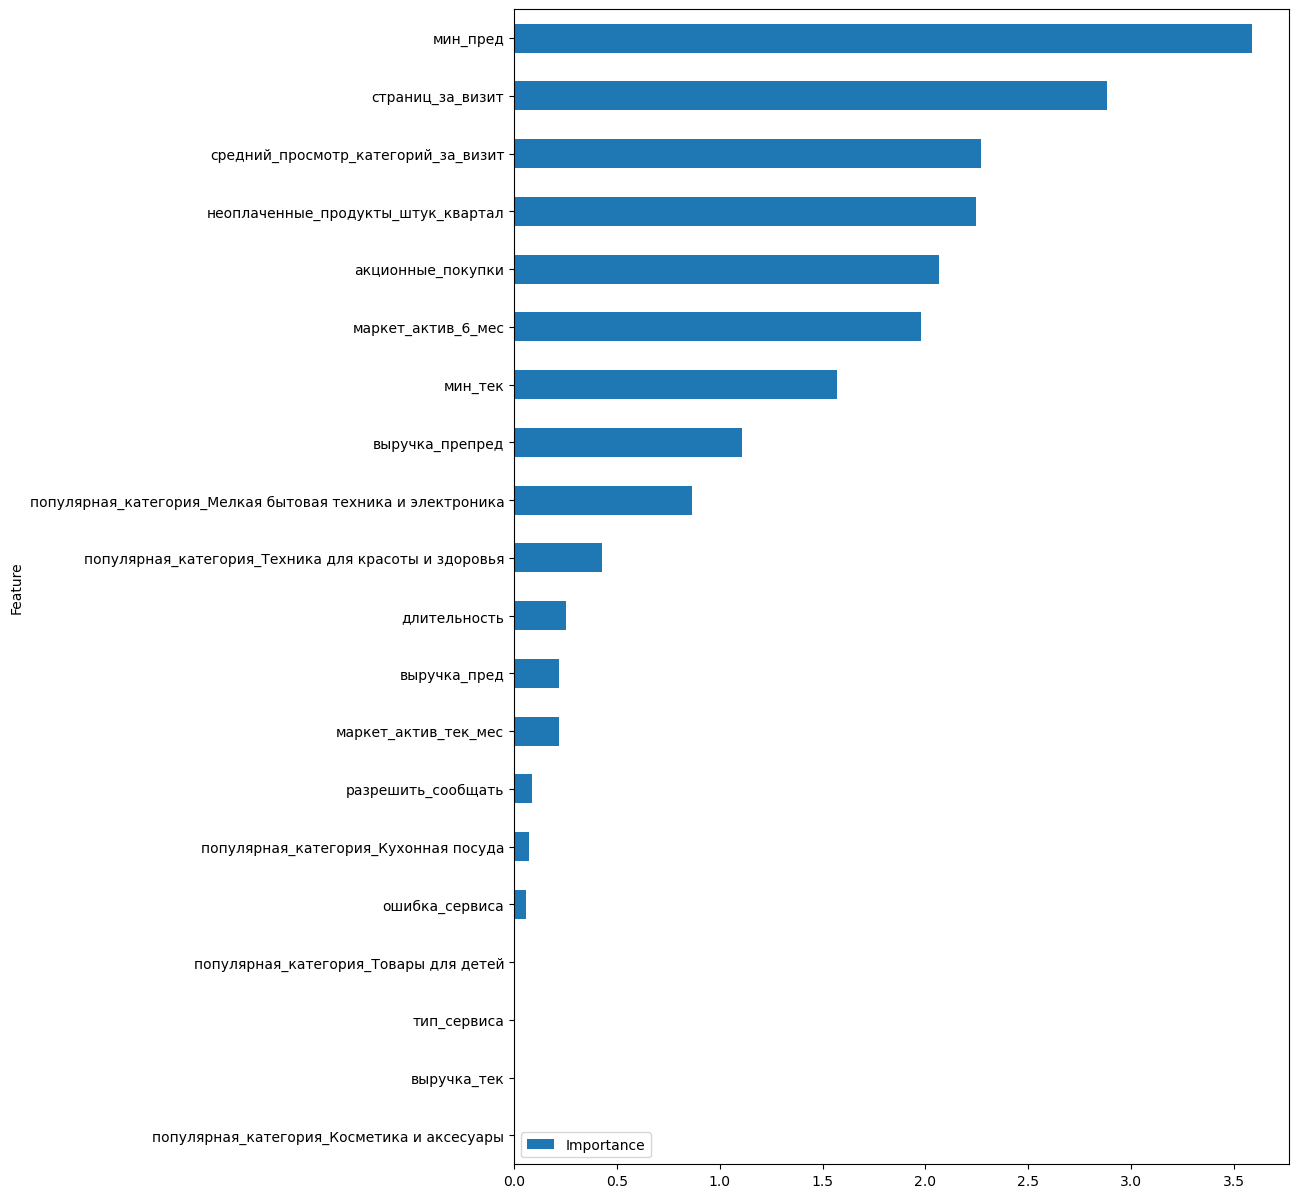

In [110]:
best_model = GridsearchCV.best_estimator_
final_model = best_model.named_steps ['model']

preprocessor = best_model.named_steps['preprocessor']
ohe_feature_names = preprocessor.named_transformers_['ohe']['ohe'].get_feature_names_out(ohe_columns)
ord_feature_names = ord_columns
num_feature_names = num_columns
feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

coef = final_model.coef_[0]
feature_importance = pd.DataFrame ({'Feature': feature_names, 'Importance': np.abs(coef)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 15))

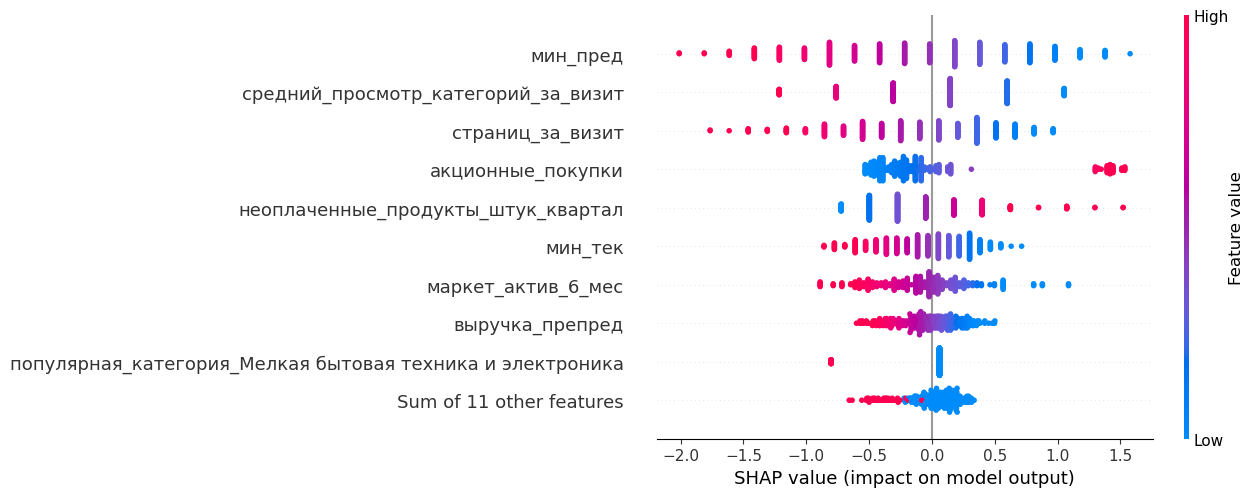

In [112]:
explainer = shap.LinearExplainer (final_model, preprocessor.transform(X_test), feature_names = feature_names)
shap_values = explainer(preprocessor.transform(X_test))
shap.plots.beeswarm(shap_values) 

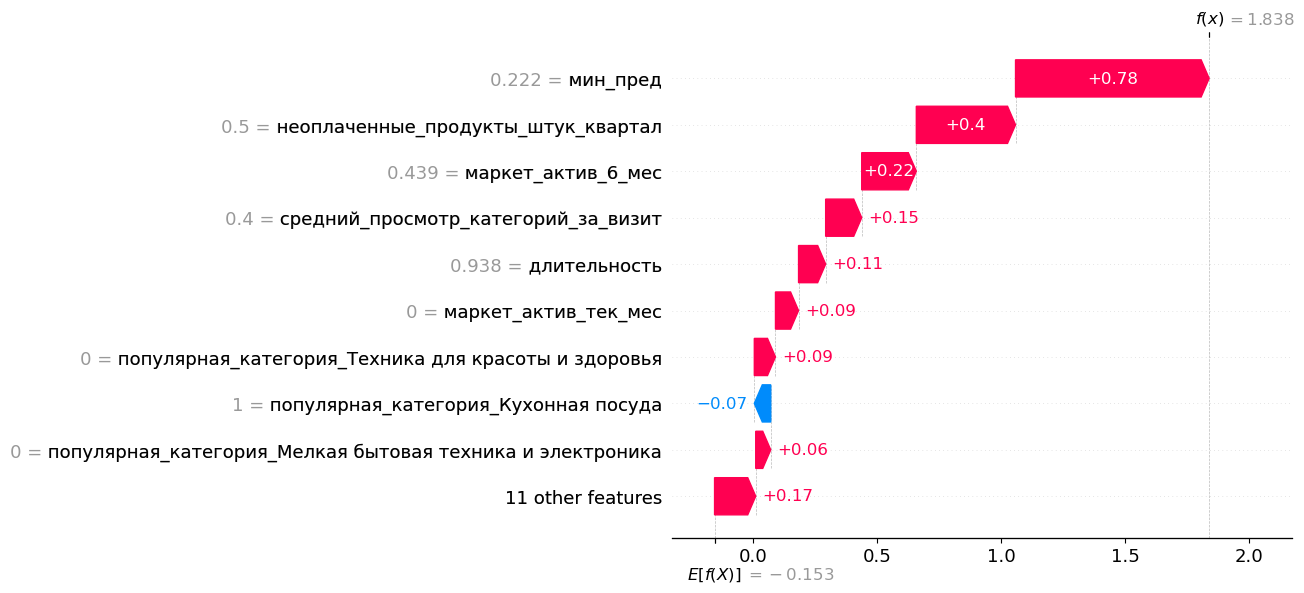

In [113]:
shap.plots.waterfall(shap_values[1]) 

**Вывод по данному пункту** 

1. Сильнее всего влияют следующие признаки: Минуты пораченные в приложении в текущем месяце и предыдущем, страниц за визит, просмотр категорий за визит, количество неоплаченных продуктов, акционные покупки, маркет_актив_6_месяц

2. меньше всего вляют на решение модели следющие показатели: выручка, категория, ошибки сервиса, разрешение на сообщения, длительность с компанией 

Исходя из графиков анализа Шепи, то видно что сильнее всего влияет на классификацию первые 5-6 признаков (минут портаченных, страниц за визит, средний просмотр категорий за визит), сильнее всего перетягивает в сторону 1 признак о потраченных минутах. 

## Сегментация покупателей
1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 
Проведите графическое и аналитическое исследование группы покупателей.
Сделайте предложения по работе с сегментом для увеличения покупательской активности.

3 Сделайте выводы о сегментах:
какой сегмент вы взяли для дополнительного исследования,
какие предложения вы сделали и почему.

In [121]:
X_segmentation = pd.merge (X_segmentation, money, left_on = 'id', right_on = 'id')

In [123]:
X_segmentation.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред,выручка_препред,выручка_тек,мин_пред,мин_тек,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95


Сегментируем данные по самой большой категории закупок **"Товары для детей"**. Предположим, как увеличить её покупательскую активность. 

Дополнительно изучим ее значения прибыльности относительно других категорий. 

In [126]:
y_test_pred_segment = GridsearchCV.predict_proba (X)
y_test_pred_segment = y_test_pred_segment [:, 1]

array_segment_df = pd.DataFrame({'вероятность': y_test_pred_segment})

X_segmentation_new = pd.concat ([X_segmentation, array_segment_df] ,axis = 1)
X_segmentation_new = X_segmentation_new[['id', 'вероятность' , 'прибыль']]

# сформируем датасет тех пользователей которых нельзя терять и о которых поскольку постольку

X_segmentation_new_important = X_segmentation_new[(X_segmentation_new['прибыль'] >= 3) & 
                                                 (X_segmentation_new['вероятность'] >= 0.75)]
X_segmentation_new_unimportant = X_segmentation_new[(X_segmentation_new['прибыль'] < 3) | 
                                                 (X_segmentation_new['вероятность'] < 0.75)]

**Выделили итоговый датасет в котором отображается вероятность снижения и прибыль которую приносят пользователи.** Построим график

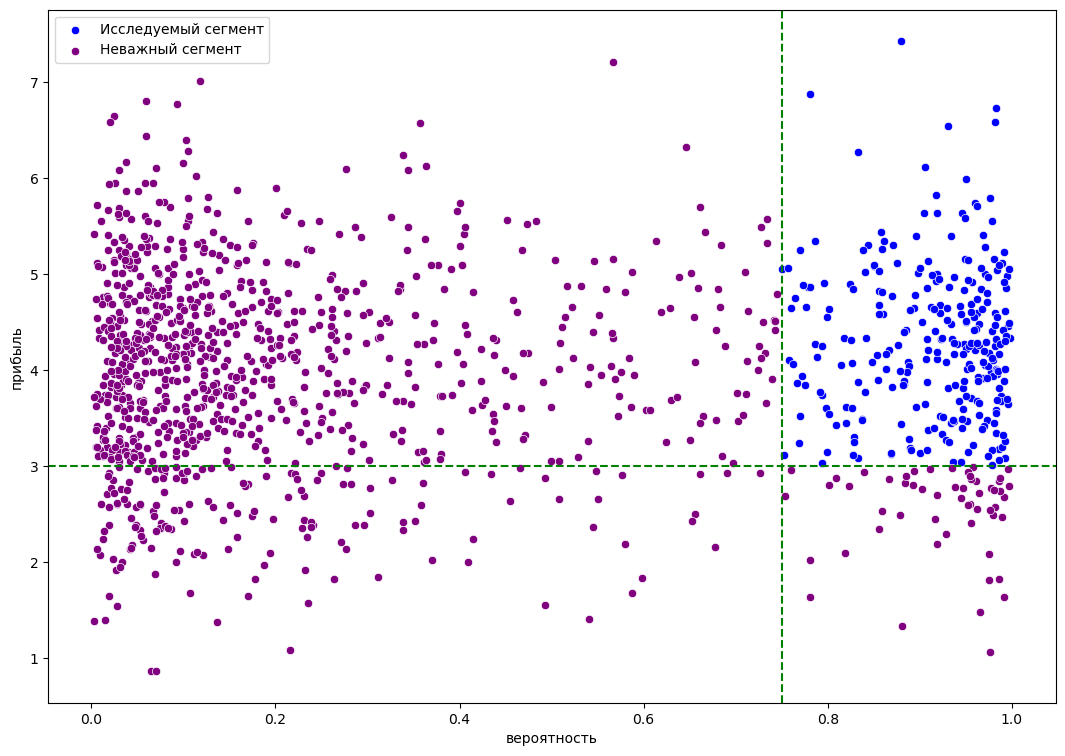

In [128]:
plt.figure (figsize = (13,9))
sns.scatterplot (data = X_segmentation_new_important , x = 'вероятность', y= 'прибыль', 
                 label = 'Исследуемый сегмент', color = 'blue')
sns.scatterplot (data = X_segmentation_new_unimportant, x = 'вероятность', y= 'прибыль', 
                 label = 'Неважный сегмент', color = 'purple')
plt.legend()
plt.axvline (x= 0.75, color = 'green', linestyle = '--')
plt.axhline (y=3, color ='green', linestyle = '--')
plt.show ()

Выдели группу пользователей которая интересная для рассмотрения, потому что: 
1. Они приносят максимальное количество прибыли т.е. не находятся внизу списка по прибыльности
2. Вероятность потерять этих персонажей высока

Исходя из приведенных выводов, можно сделать что на данных людей нужно в первую очередь обратить внимание и постараться не допустить снижение их активности. 

Выведем их id

In [130]:
X_segmentation_new_important['id']

0       215349
2       215351
3       215352
5       215354
7       215356
         ...  
1082    216433
1248    216599
1256    216607
1284    216635
1285    216636
Name: id, Length: 282, dtype: int64

In [133]:
#Выделяем 2 датасета с изучаемыми пользователями и всеми остальными 
X_segmentation_VIP = X_segmentation[X_segmentation['id'].isin (X_segmentation_new_important['id'])]
X_segmentation_oher = X_segmentation[~(X_segmentation['id'].isin (X_segmentation_new_important['id']))]
#изучим последовательно каждый признак и их различие 


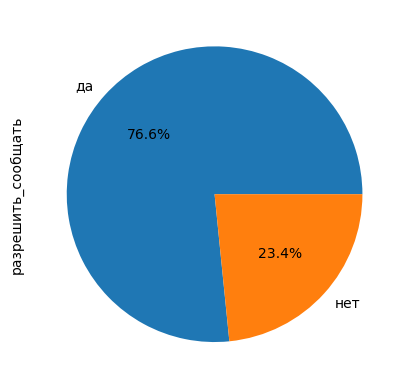

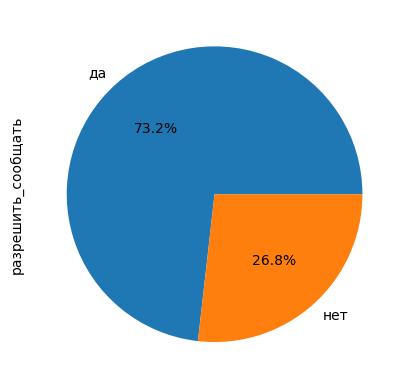

In [134]:
for i in [X_segmentation_VIP, X_segmentation_oher]:
    (i
    .groupby('разрешить_сообщать') ['разрешить_сообщать']
    .count()
    .plot (kind = 'pie',  autopct = '%1.1f%%'))
    plt.title = i 
    plt.show()

маркет_актив_6_мес


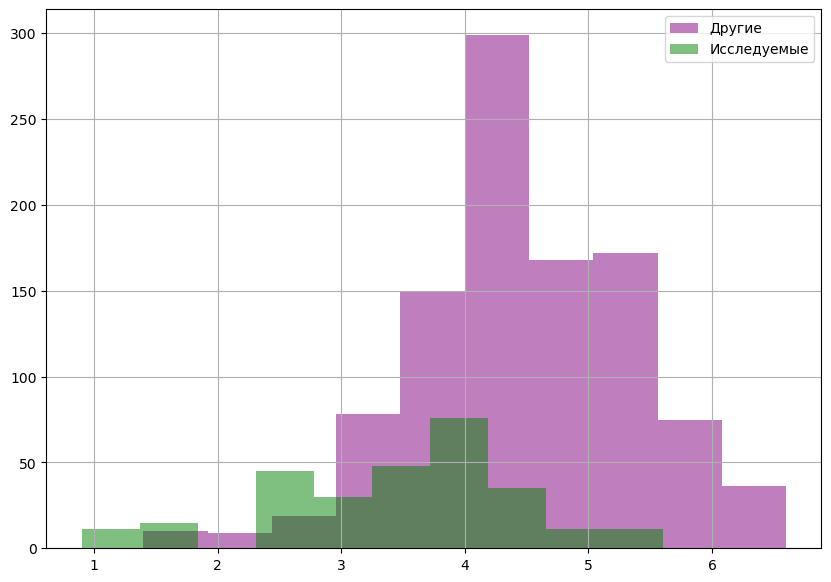

маркет_актив_тек_мес


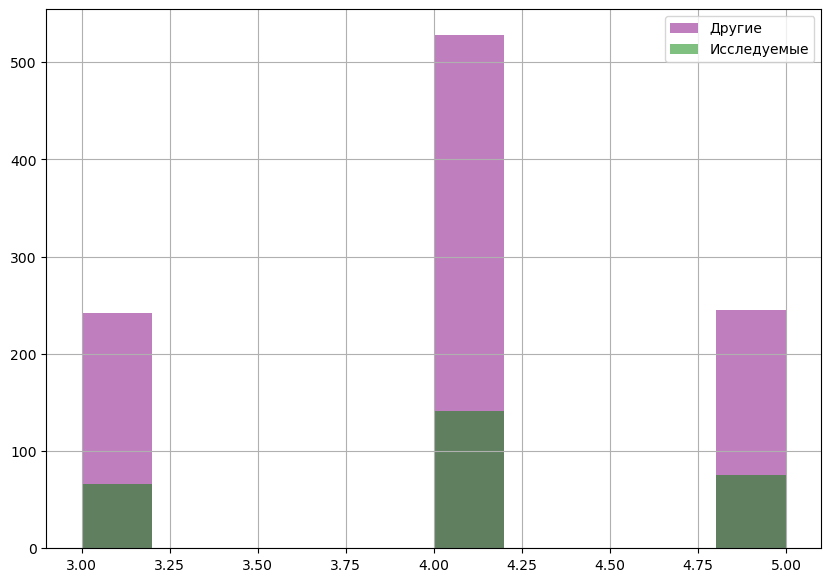

длительность


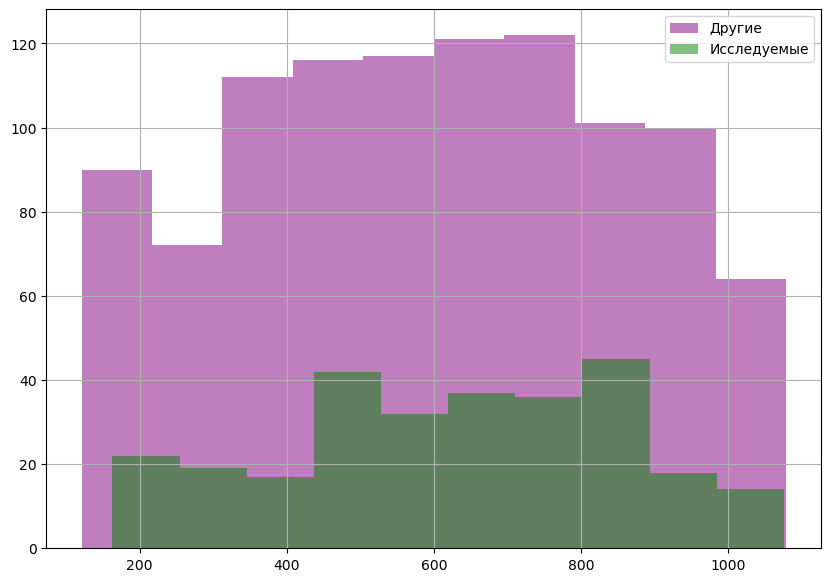

акционные_покупки


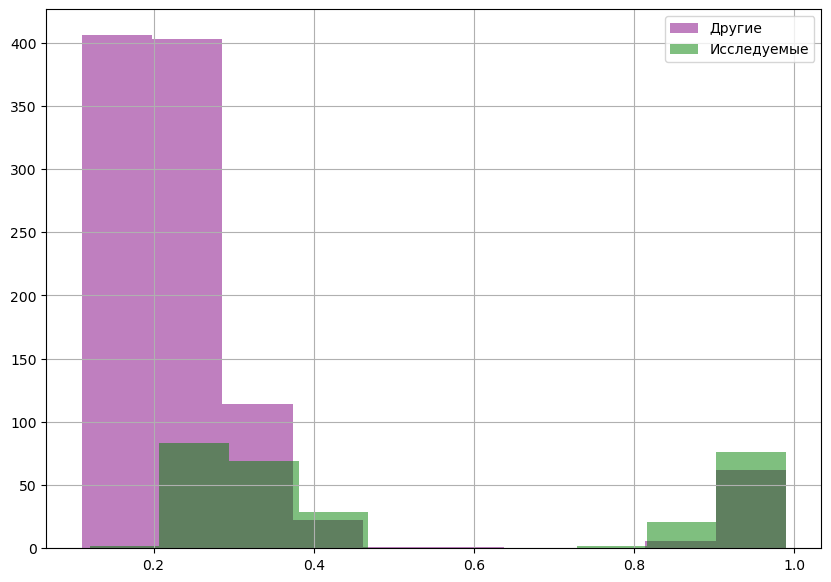

средний_просмотр_категорий_за_визит


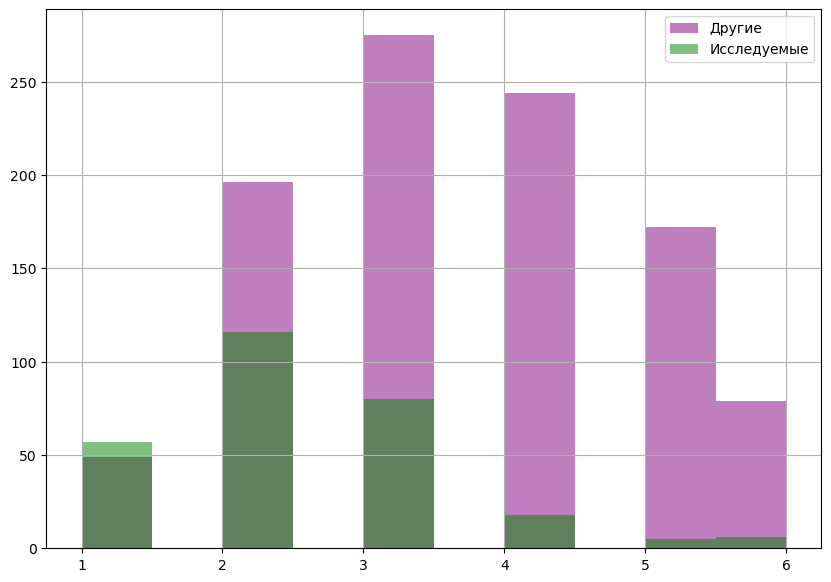

неоплаченные_продукты_штук_квартал


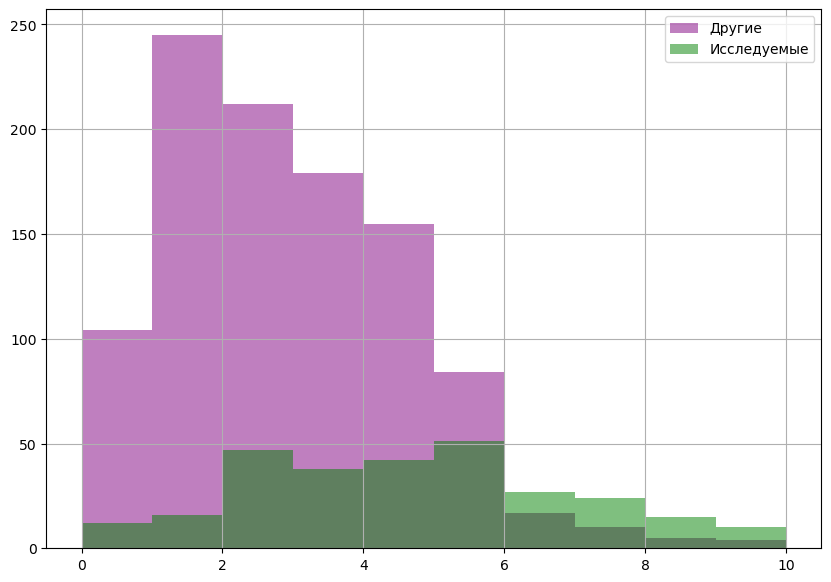

ошибка_сервиса


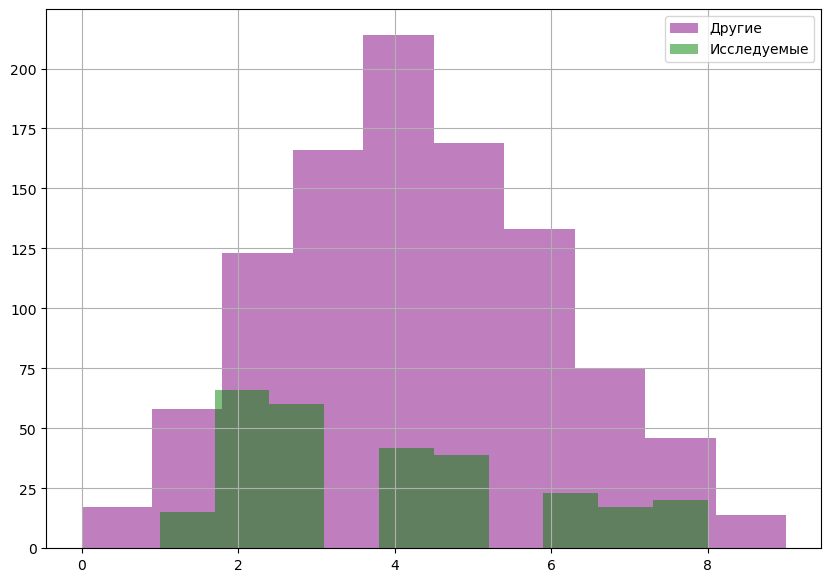

страниц_за_визит


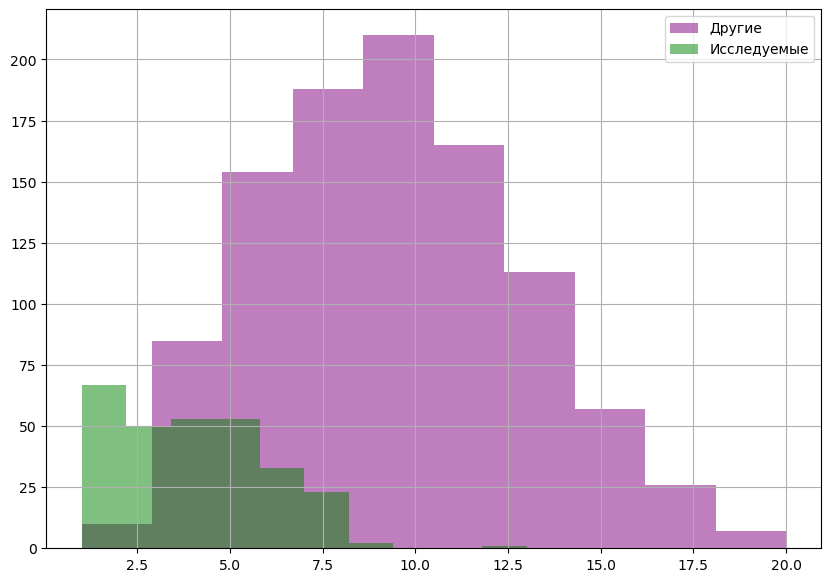

выручка_пред


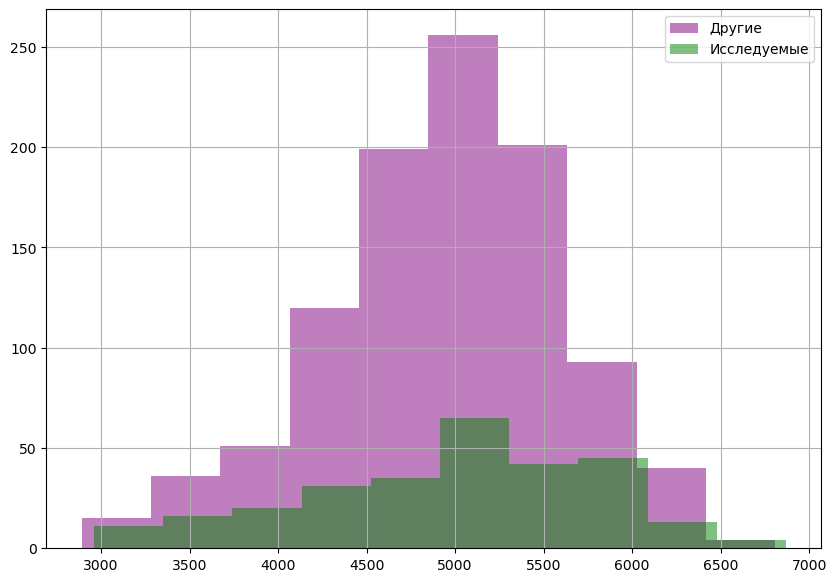

выручка_препред


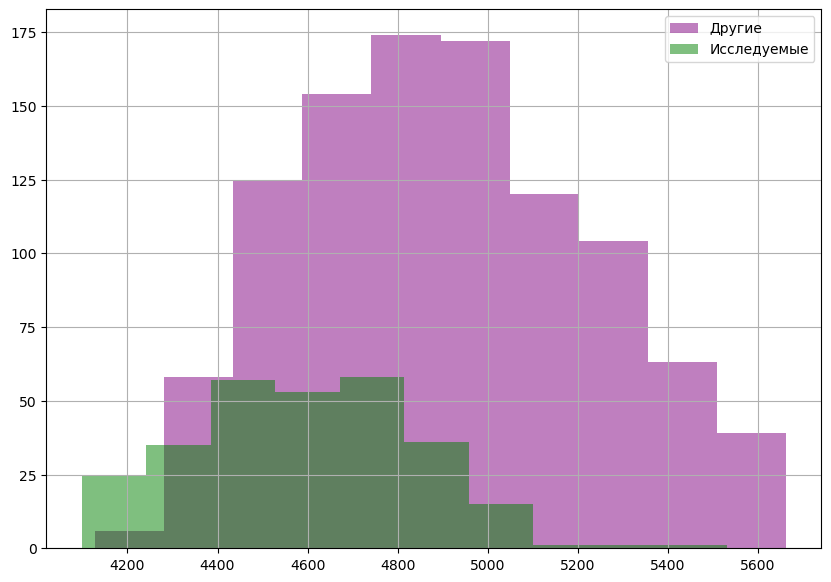

выручка_тек


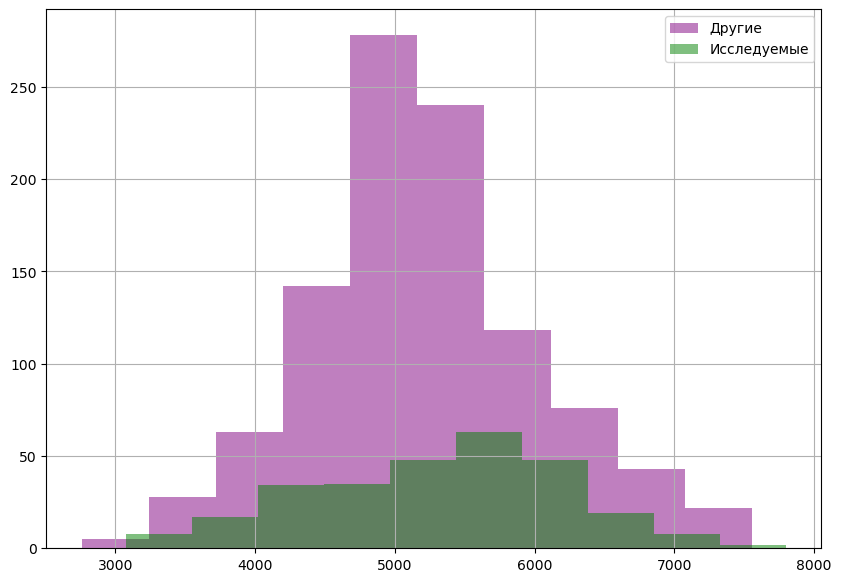

мин_пред


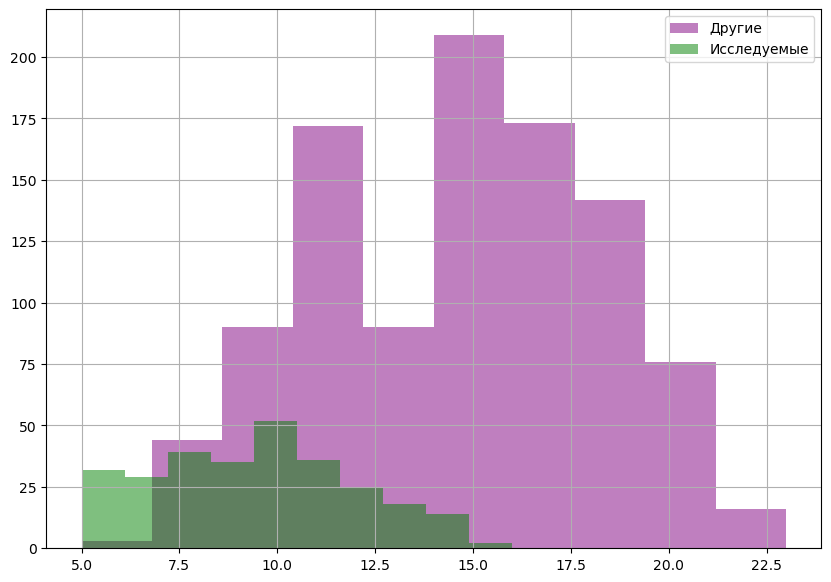

мин_тек


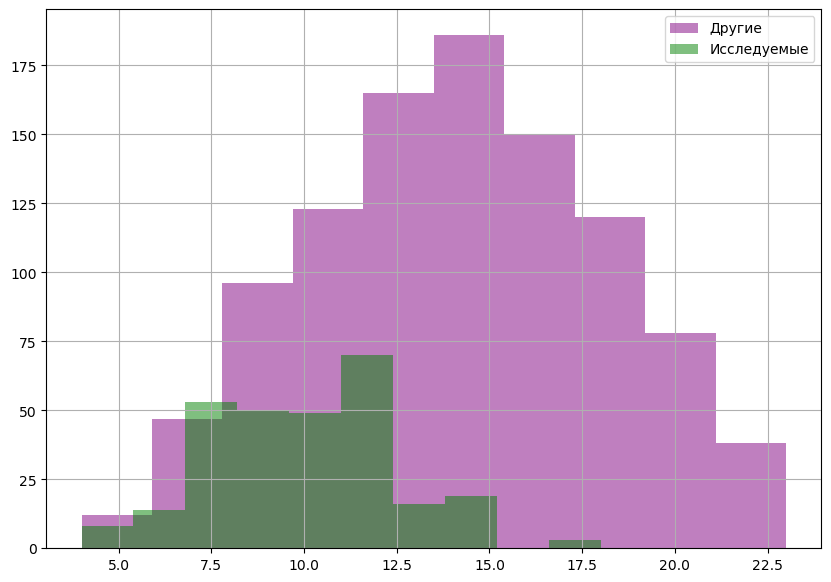

прибыль


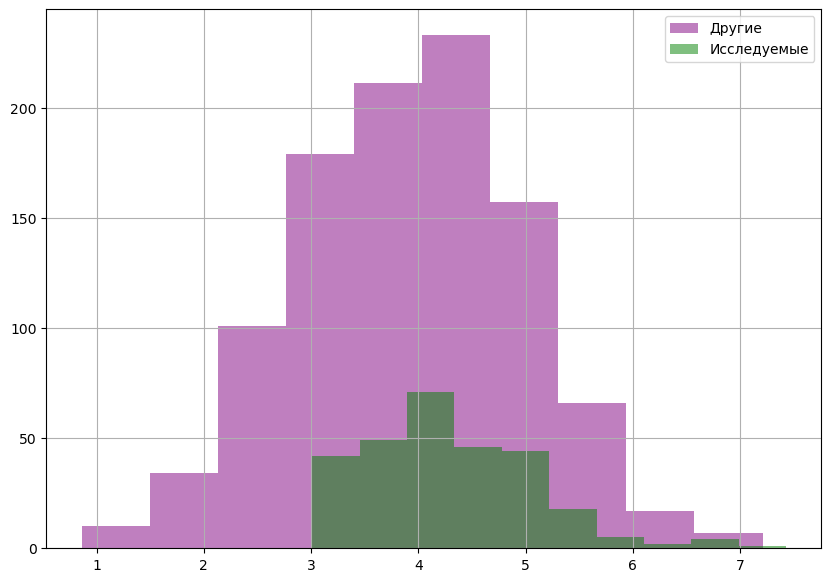

In [135]:
for i in X_segmentation_oher.select_dtypes(include = 'number').columns.drop('id'):
    print (i)
    plt.figure (figsize = (10, 7))
    X_segmentation_oher[i].hist( color = 'purple', label = 'Другие', alpha=0.5)
    X_segmentation_VIP[i].hist( color = 'green', label = 'Исследуемые', alpha=0.5)
    plt.legend()
    plt.show()

**Вывод** 

Исходя из проведенного сегментационного анализа можно сделать следующие выводы, что: 
1. Люди, в целом одинаково отказываются от рассылки, по сравнению с остальными пользователями, что видно из круговой диаграммы, т.е. она их не беспокоит 
2. по гистограмме "маркет_актив_6_мес (реднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.)" видно, что пользователи не выглядит как классическое распределение как остальные пользователи, т.е. не хватает активности в этом пункте, необходимо увеличивать количество рассылок на человека. 
3. По параметрам "маркет_актив_тек_мес", "длительность", "ошибка_сервиса" все окей различий нет 
4. "акционные_покупки" видно что пользователи данной категории больше нацелены на покупки по акциаям=> что необходимо увеличивать кол-во предложений акционных товаров
5. "Средний просмотр категорий" и "страниц_за_визит" видно что пользователи данной категории нацелены больше на просмотр 1-3 категорий, т.е. скорее всего именно на товары для детей
6. "неоплаченные_продукты_штук_квартал" так же по распределению видно что они любят набирать разных товаров в корзину


Из этого можно сформировать вывод который опишу в общем выводе, пункт 11

## Вывод

Задача была поставлена преобразовать, проверить данные, для применения различных моделей МО, которые могут с наибольшей точностью предсказать снизилась ли пользовательская активность или нет. 

Данные были подготовлены, проверены на наличие явных и неявных дубликатов. Найден один явный выброс, заменен на медианное значение. 

Для поиска лучшей модели был написан пайплайн, у которого задан переобором как минимум 1 гипперпараметр, рассмотрены 4 модели (линейной регрессии, svm, деревья решений, ближайшие соседи), 2 метода кодировки категориальных признаков и 2 метода масштабирования численных признаков. 

Лучшей моделью оказалась модель Линейной регрессии.

Мультиколлинеарности среди признаков нет. 

Анализ признаков влияния: 

1. Сильнее всего влияют следующие признаки: Минуты пораченные в приложении в текущем месяце и предыдущем, страниц за визит, просмотр категорий за визит, количество неоплаченных продуктов, акционные покупки, маркет_актив_6_месяц

2. меньше всего вляют на решение модели следющие показатели: выручка, категория, ошибки сервиса, разрешение на сообщения, длительность с компанией 

Исходя из графиков анализа Шепи, то видно что сильнее всего влияет на классификацию первые 5-6 признаков (минут портаченных, страниц за визит, средний просмотр категорий за визит), сильнее всего перетягивает в сторону 1 признак о потраченных минутах. 

Выводы сформированные из анализа категории "Товары для детей":
1. Люди, в целом одинаково отказываются от рассылки, по сравнению с остальными пользователями, что видно из круговой диаграммы, т.е. она их не беспокоит 
2. по гистограмме "маркет_актив_6_мес (реднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.)" видно, что пользователи не выглядит как классическое распределение как остальные пользователи, т.е. не хватает активности в этом пункте, необходимо увеличивать количество рассылок на человека. 
3. По параметрам "маркет_актив_тек_мес", "длительность", "ошибка_сервиса" все окей различий нет 
4. "акционные_покупки" видно что пользователи данной категории больше нацелены на покупки по акциаям=> что необходимо увеличивать кол-во предложений акционных товаров
5. "Средний просмотр категорий" и "страниц_за_визит" видно что пользователи данной категории нацелены больше на просмотр 1-3 категорий, т.е. скорее всего именно на товары для детей
6. "неоплаченные_продукты_штук_квартал" так же по распределению видно что они любят набирать разных товаров в корзину

Рекомендации к бизнесу следующие: 
Необходимо увеличить рассылку на данных пользователей, в рассылке нужно указывать точечно товары из предпочитаемой категории, но заваливать количеством товаров, т.к. смотрят по 1-2 категории и желательно чтобы были акционные товары, т.к. нацелены они именно на них.
Портрет типового клиента: Домохозяйка сидящая дома с ребенком, выбирающая для него товары, подбирающая по скидке. Уменьшение внимания с стороны платформы приводит к вовлеченности пользователя. 